In [1]:
# 📦 Import all necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score

import shap
import warnings
warnings.filterwarnings("ignore")


In [2]:
# Step 2: Set sample size and reproducibility
n_samples = 1000  # You can change this if needed
np.random.seed(42)


In [3]:
# Step 3: Generate synthetic features

# Income between $20k to $150k
income = np.random.randint(20000, 150001, n_samples)

# RRSP between $0 and $28,000 (CRA 2025 limit is ~$30k)
rrsp = np.random.randint(0, 28001, n_samples)

# Tuition Amounts (for students or past credits)
tuition = np.random.randint(0, 20001, n_samples)

# Dependents (0 to 4)
dependents = np.random.randint(0, 5, n_samples)

# Province selection
province = np.random.choice(['ON', 'QC', 'BC', 'AB', 'MB', 'NS', 'NB', 'NL', 'SK', 'PE'], n_samples)

# Marital status
marital_status = np.random.choice(['Single', 'Married', 'Common-Law'], n_samples)


In [4]:
# Step 4: Simulate Refund Amount (simplified logic)

# Formula: RRSP = 18% tax credit, Tuition = 15%, Deduction per dependent = $1000
refund_amount = (
    rrsp * 0.18 +
    tuition * 0.15 +
    dependents * 1000 -
    income * 0.05  # Simulate some tax owed
)

# Cap refunds at 0 (no negative refunds)
refund_amount = np.where(refund_amount < 0, 0, refund_amount)

# Binary classification target
refund_yn = np.where(refund_amount > 0, 1, 0)


In [5]:
# Step 5: Build DataFrame

df = pd.DataFrame({
    'Income': income,
    'RRSP': rrsp,
    'Tuition_Amount': tuition,
    'Dependents': dependents,
    'Province': province,
    'Marital_Status': marital_status,
    'Refund_Amount': refund_amount,
    'Refund_YN': refund_yn
})

# Preview the data
df.head()


,Income,RRSP,Tuition_Amount,Dependents,Province,Marital_Status,Refund_Amount,Refund_YN
0,141958,13216,9155,3,NB,Common-Law,0.00,0
1,35795,22516,10426,0,AB,Single,3827.03,1
2,20860,24275,10233,3,SK,Common-Law,7861.45,1
3,123694,27084,1828,4,MB,Single,2964.62,1
4,148106,2779,12260,2,AB,Married,0.00,0


In [6]:
# Step 6: Save to CSV for later stages

df.to_csv("taxsave_synthetic_data.csv", index=False)
print("✅ Dataset created and saved!")


✅ Dataset created and saved!


In [7]:
# Load your saved synthetic dataset
import pandas as pd

df = pd.read_csv("taxsave_synthetic_data.csv")
df.head()


,Income,RRSP,Tuition_Amount,Dependents,Province,Marital_Status,Refund_Amount,Refund_YN
0,141958,13216,9155,3,NB,Common-Law,0.00,0
1,35795,22516,10426,0,AB,Single,3827.03,1
2,20860,24275,10233,3,SK,Common-Law,7861.45,1
3,123694,27084,1828,4,MB,Single,2964.62,1
4,148106,2779,12260,2,AB,Married,0.00,0


In [8]:
# Basic checks to confirm structure
print(df.info())
print(df.describe())
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Income          1000 non-null   int64  
 1   RRSP            1000 non-null   int64  
 2   Tuition_Amount  1000 non-null   int64  
 3   Dependents      1000 non-null   int64  
 4   Province        1000 non-null   object 
 5   Marital_Status  1000 non-null   object 
 6   Refund_Amount   1000 non-null   float64
 7   Refund_YN       1000 non-null   int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 62.6+ KB
None
              Income          RRSP  Tuition_Amount   Dependents  \
count    1000.000000   1000.000000     1000.000000  1000.000000   
mean    85838.794000  14174.909000     9959.625000     2.031000   
std     37817.509802   8118.205614     5731.889485     1.421992   
min     20206.000000      9.000000       11.000000     0.000000   
25%     53567.250000   6994.000000     510

In [9]:
# One-hot encode Province and Marital_Status
df_encoded = pd.get_dummies(df, columns=['Province', 'Marital_Status'], drop_first=True)

df_encoded.head()


,Income,RRSP,Tuition_Amount,Dependents,Refund_Amount,Refund_YN,Province_BC,Province_MB,Province_NB,Province_NL,Province_NS,Province_ON,Province_PE,Province_QC,Province_SK,Marital_Status_Married,Marital_Status_Single
0,141958,13216,9155,3,0.00,0,False,False,True,False,False,False,False,False,False,False,False
1,35795,22516,10426,0,3827.03,1,False,False,False,False,False,False,False,False,False,False,True
2,20860,24275,10233,3,7861.45,1,False,False,False,False,False,False,False,False,True,False,False
3,123694,27084,1828,4,2964.62,1,False,True,False,False,False,False,False,False,False,False,True
4,148106,2779,12260,2,0.00,0,False,False,False,False,False,False,False,False,False,True,False


In [10]:
# Define X and y for both tasks

# Drop target columns from input features
X = df_encoded.drop(['Refund_Amount', 'Refund_YN'], axis=1)

# Target for classification
y_class = df_encoded['Refund_YN']

# Target for regression
y_reg = df_encoded['Refund_Amount']


In [11]:
from sklearn.preprocessing import StandardScaler

# Scale X features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [13]:
from sklearn.model_selection import train_test_split

# Split for classification
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_scaled, y_class, test_size=0.2, random_state=42)

# Split for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_scaled, y_reg, test_size=0.2, random_state=42)


Evaluation of Models

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Train model
logreg = LogisticRegression()
logreg.fit(X_train_cls, y_train_cls)

# Predict
y_pred_logreg = logreg.predict(X_test_cls)

# Evaluate
print("🔎 Logistic Regression Performance")
print(confusion_matrix(y_test_cls, y_pred_logreg))
print(classification_report(y_test_cls, y_pred_logreg))


🔎 Logistic Regression Performance
[[ 44   2]
 [  1 153]]
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        46
           1       0.99      0.99      0.99       154

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200



In [15]:
from sklearn.ensemble import RandomForestClassifier

# Train model
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_cls, y_train_cls)

# Predict
y_pred_rf = rf_clf.predict(X_test_cls)

# Evaluate
print("🌲 Random Forest Classifier Performance")
print(confusion_matrix(y_test_cls, y_pred_rf))
print(classification_report(y_test_cls, y_pred_rf))


🌲 Random Forest Classifier Performance
[[ 36  10]
 [  0 154]]
              precision    recall  f1-score   support

           0       1.00      0.78      0.88        46
           1       0.94      1.00      0.97       154

    accuracy                           0.95       200
   macro avg       0.97      0.89      0.92       200
weighted avg       0.95      0.95      0.95       200



In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Train model
linreg = LinearRegression()
linreg.fit(X_train_reg, y_train_reg)

# Predict
y_pred_linreg = linreg.predict(X_test_reg)

# Evaluate
print("📊 Linear Regression Results")
print("MSE:", mean_squared_error(y_test_reg, y_pred_linreg))
print("R² Score:", r2_score(y_test_reg, y_pred_linreg))


📊 Linear Regression Results
MSE: 590033.7010518215
R² Score: 0.8710721589042459


In [17]:
from sklearn.ensemble import RandomForestRegressor

# Train model
rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train_reg, y_train_reg)

# Predict
y_pred_rf_reg = rf_reg.predict(X_test_reg)

# Evaluate
print("🌲 Random Forest Regressor Results")
print("MSE:", mean_squared_error(y_test_reg, y_pred_rf_reg))
print("R² Score:", r2_score(y_test_reg, y_pred_rf_reg))


🌲 Random Forest Regressor Results
MSE: 212710.38874025695
R² Score: 0.9535208054217376


In [18]:
!pip install shap


In [28]:
import shap

# Convert X to all float (safe fix for object dtype error)
X_numeric = X.astype(float)

# Create the SHAP explainer using numeric-safe DataFrame
explainer = shap.Explainer(rf_clf, X_numeric)


In [29]:
# Generate SHAP values
shap_values = explainer(X_numeric)


 93%|=================== | 1851/2000 [00:13<00:01]       

<Figure size 640x480 with 0 Axes>

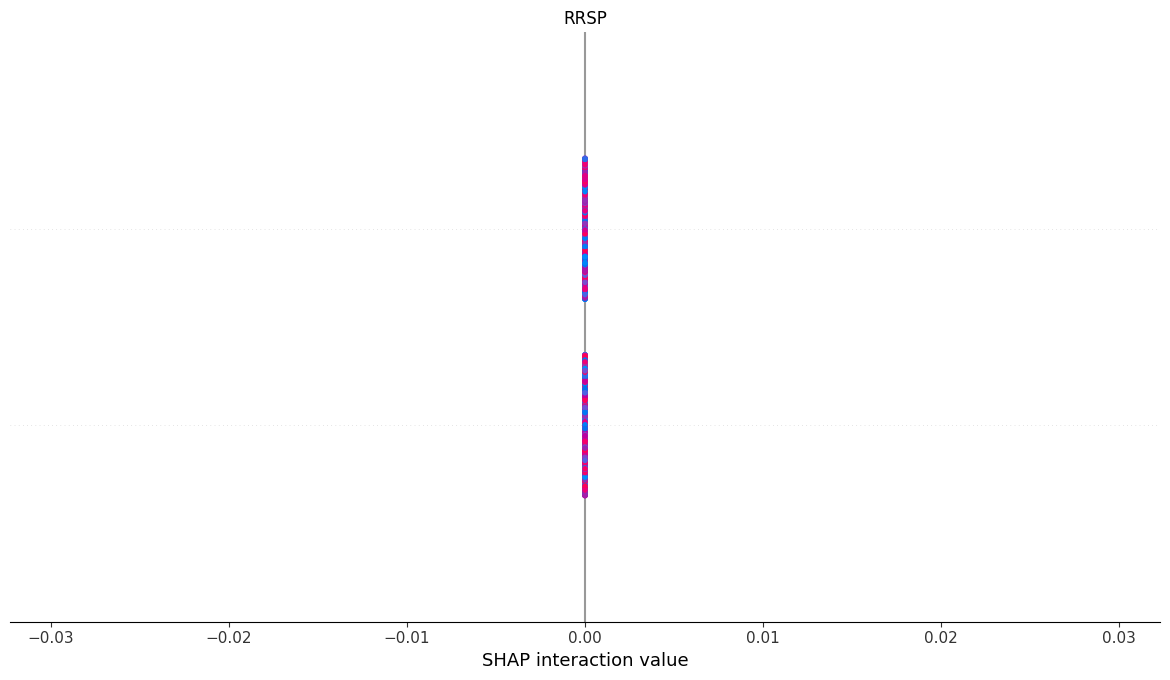

In [30]:
# Global summary plot
shap.summary_plot(shap_values, X_numeric)


In [31]:
print("X shape:", X.shape)
print("X columns:", X.columns.tolist())


X shape: (1000, 15)
X columns: ['Income', 'RRSP', 'Tuition_Amount', 'Dependents', 'Province_BC', 'Province_MB', 'Province_NB', 'Province_NL', 'Province_NS', 'Province_ON', 'Province_PE', 'Province_QC', 'Province_SK', 'Marital_Status_Married', 'Marital_Status_Single']


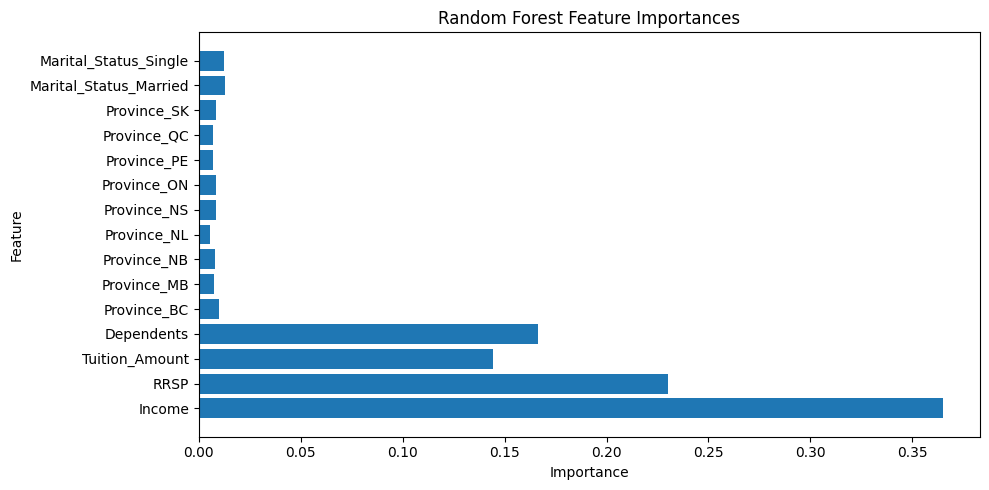

In [33]:
import matplotlib.pyplot as plt

# Save feature importances to image
plt.figure(figsize=(10, 5))
plt.barh(X.columns, rf_clf.feature_importances_)
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("feature_importance.png")  # ✅ Saved
plt.show()


<Figure size 640x480 with 0 Axes>

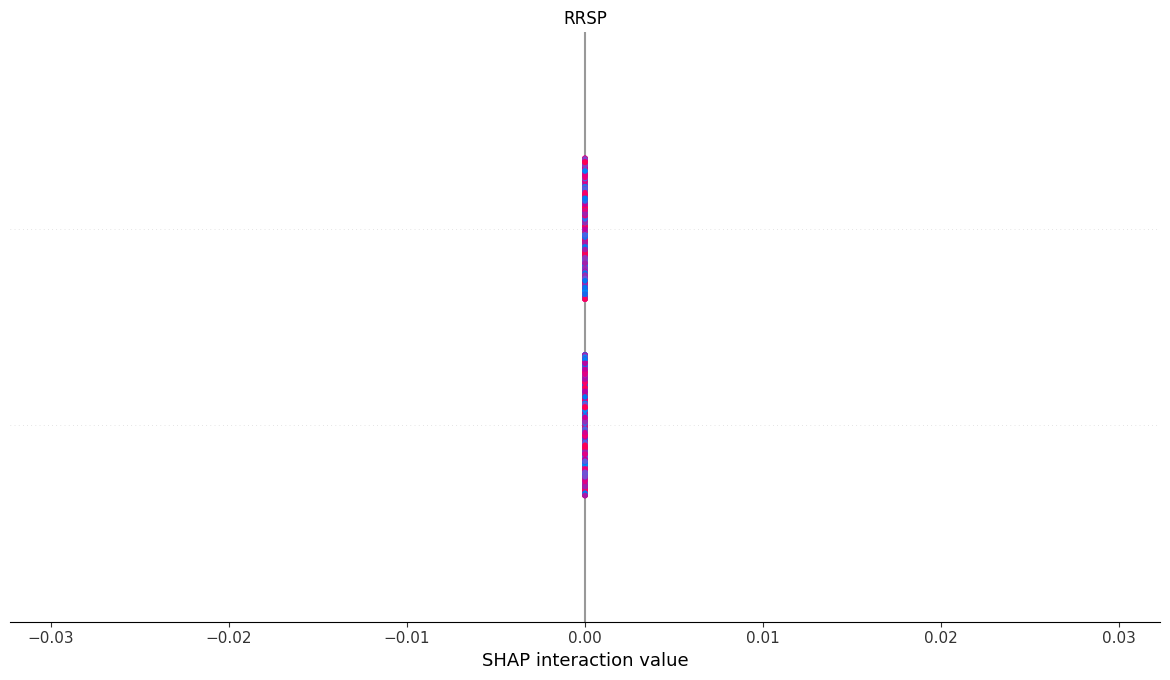

In [34]:
# Save SHAP summary plot
shap.summary_plot(shap_values, X, show=False)
plt.savefig("shap_summary.png", bbox_inches='tight')  # ✅ Saved
plt.show()


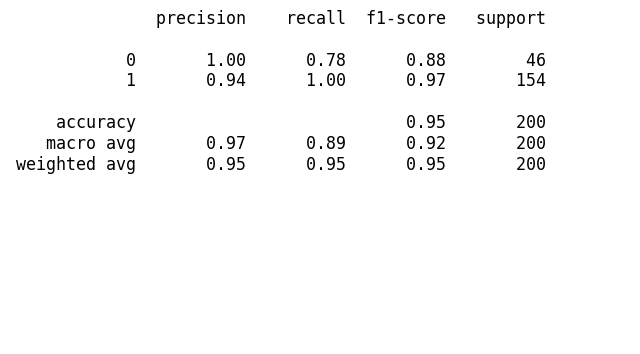

In [36]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Generate text
report_text = classification_report(y_test_cls, y_pred_rf)

# Plot text to save
plt.figure(figsize=(8, 4))
plt.axis('off')
plt.text(0.01, 0.5, report_text, fontsize=12, family='monospace')
plt.savefig("classification_report.png", bbox_inches='tight')  # ✅ Saved
plt.show()


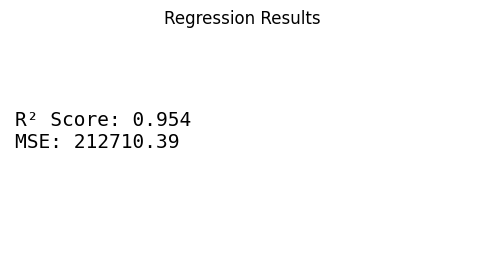

In [37]:
from sklearn.metrics import mean_squared_error, r2_score

# Generate text
regression_text = f"R² Score: {r2_score(y_test_reg, y_pred_rf_reg):.3f}\nMSE: {mean_squared_error(y_test_reg, y_pred_rf_reg):.2f}"

# Plot text
plt.figure(figsize=(6, 3))
plt.axis('off')
plt.text(0.01, 0.5, regression_text, fontsize=14, family='monospace')
plt.title("Regression Results")
plt.savefig("regression_results.png", bbox_inches='tight')  # ✅ Saved
plt.show()


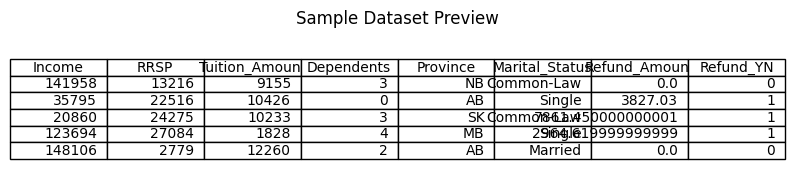

In [38]:
# Display and save df.head() as an image
fig, ax = plt.subplots(figsize=(10, 2))
ax.axis('off')
table = ax.table(cellText=df.head().values, colLabels=df.columns, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
plt.title("Sample Dataset Preview")
plt.savefig("dataset_head.png", bbox_inches='tight')  # ✅ Saved
plt.show()


In [40]:
# Import SHAP & setup JS rendering
import shap
shap.initjs()

# Pick a sample to explain (change index to see different users)
i = 0  # You can try 0, 1, 2, etc.


In [42]:
# Convert X to numeric (float64)
X_numeric = X.astype(float)


In [43]:
# Create SHAP explainer on numeric input
explainer = shap.Explainer(rf_clf, X_numeric)

# Generate SHAP values
shap_values = explainer(X_numeric)


In [56]:
i = 1  # Choose the row/user

# Extract SHAP values for class 1 only
class_index = 1  # Refund = Yes
shap_force_values = shap_values[i].values[:, class_index]

# Generate force plot
shap.plots.force(
    explainer.expected_value[class_index],     # base value for class 1
    shap_force_values,                         # SHAP values for class 1
    X_numeric.iloc[i],                         # feature values
    feature_names=X.columns                    # feature names
)


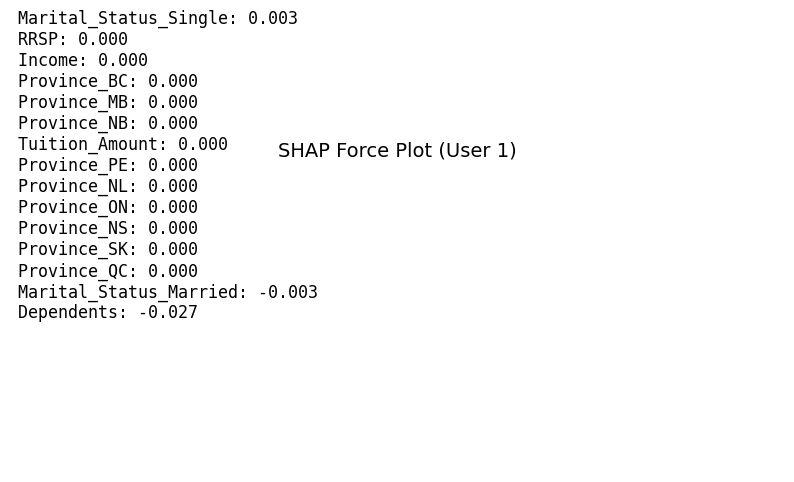

In [57]:
import matplotlib.pyplot as plt

# Create a simple text-based fallback for sharing
top_feats = pd.Series(shap_force_values, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 4))
plt.axis('off')
plt.text(0.01, 0.5, "\n".join([f"{feat}: {val:.3f}" for feat, val in top_feats.items()]), fontsize=12, family='monospace')
plt.title(f"SHAP Force Plot (User {i})", fontsize=14)
plt.savefig(f"shap_force_user_{i}.png", bbox_inches='tight')
plt.show()
